# Amazon Unlocked Phone Analysis

In this analysis I'm analyzing a dataset of over 400,000 reviews for unlocked cellphones on Amazon.com. Each review has information on the phone's listing name, brand, and price, as well as the review text and rating.

For the first half of this analysis I'll examine phone name, brand, and price. I'm curious to see what the most popular phones and brands are, and how these variables impact price and review ratings.

In the second half I'll perform sentiment analysis on the reviews themselves by building a model that can accurately discern whether the reviewer's opinions are generally positive, neutral, or negative.

## Setup and a quick look at the data

In [626]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pd.set_option('display.max_colwidth', -1) # visibility
pd.set_option('display.max_columns', 50)

sns.set_style("darkgrid") # plotting style
%matplotlib inline
# plots show up in notebook

np.random.seed(42) # seeding random number generator for reproducibility

In [3]:
csv = "Amazon_Unlocked_Mobile.csv"
df = pd.read_csv(csv)
df.head(2)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D700*FRONT CAMERA*ANDROID*SLIDER*QWERTY KEYBOARD*TOUCH SCREEN",Samsung,199.99,5,"I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!",1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D700*FRONT CAMERA*ANDROID*SLIDER*QWERTY KEYBOARD*TOUCH SCREEN",Samsung,199.99,4,"nice phone, nice up grade from my pantach revue. Very clean set up and easy set up. never had an android phone but they are fantastic to say the least. perfect size for surfing and social media. great phone samsung",0.0


In [665]:
data = df.copy()
data.describe()

,Price,Rating,Review Votes
count,407907.000000,413840.000000,401544.000000
mean,226.867155,3.819578,1.507237
std,273.006259,1.548216,9.163853
min,1.730000,1.000000,0.000000
25%,79.990000,3.000000,0.000000
50%,144.710000,5.000000,0.000000
75%,269.990000,5.000000,1.000000
max,2598.000000,5.000000,645.000000


- Average review rating is almost a 4 - most people are pretty happy with their new phones.
- Someone bought a phone for $2600
- Most reviews barely get any votes, with a standard deviation of 9 the average is being brought up by a few very high outliers (like the max of 645)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
Product Name    413840 non-null object
Brand Name      348669 non-null object
Price           407907 non-null float64
Rating          413840 non-null int64
Reviews         413778 non-null object
Review Votes    401544 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


- 65,000 samples are missing brand names
- Price and Review votes are also missing a couple thousand samples
- Small number of missing reviews will have to be dropped as no way to impute text

Visualizing the distributions of numerical variables:

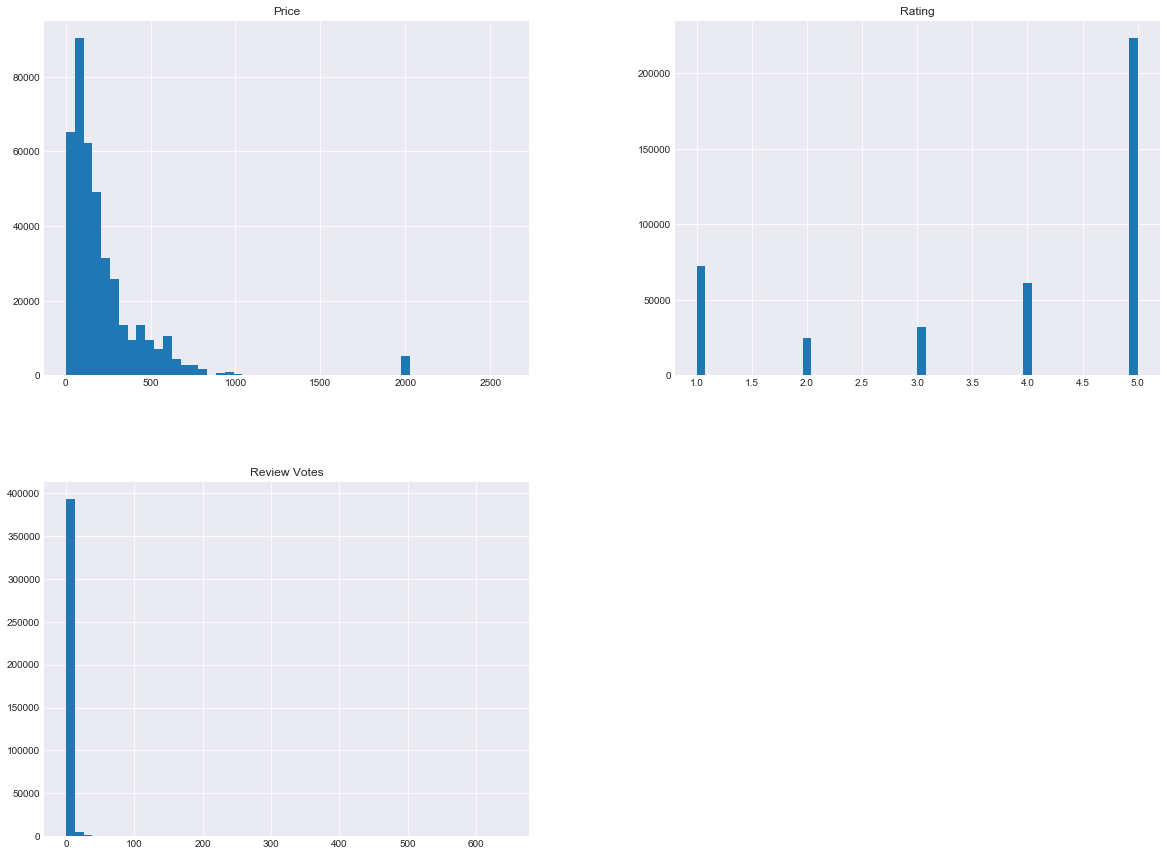

In [6]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [629]:
data["Rating"].value_counts()/len(data) # exact proportions of ratings

5    0.540318
1    0.174826
4    0.148347
3    0.076757
2    0.059753
Name: Rating, dtype: float64

- Price and review votes are right skewed (mean higher than median), ratings are left skewed (median higher than mean)
- Small number of outliers in price and review stretch the distributions out
- Ratings of 5 make up just over half of the entire rating distribution; will require stratified sampling for training/test sets

## Exploratory Analysis

### Product Name

Unique product names:

In [8]:
len(data["Product Name"].unique())

4410

Top 1000 product names ranked by frequency:

In [9]:
top1000_products = data["Product Name"].value_counts()[:1000]
top1000_products[:10]

Apple iPhone 4s 8GB Unlocked Smartphone w/ 8MP Camera, White (Certified Refurbished)          1451
Apple MF259LL/A - iPhone 4s 8GB / 8MP Camera - Unlocked - Black (Certified Refurbished)       1241
BLU Studio 5.0 C HD Unlocked Cellphone, Black                                                 1194
OtterBox Iphone 5/5S/SE Defender Case w/ Drop and Dust Proctection - Realtree AP Pink         1129
Motorola Moto E (1st Generation) - Black - 4 GB - Global GSM Unlocked Phone                   1127
Apple iPhone 5s 32GB (Silver) - AT&T                                                          1118
BLU Energy X Plus Smartphone - With 4000 mAh Super Battery- US GSM Unlocked - Grey            1111
Samsung Galaxy S Duos II S7582 DUAL SIM Factory Unlocked International Version - Black        1109
Samsung Galaxy S Duos II GT-S7582 Factory Unlocked Cellphone, International Version, White    1108
Samsung Galaxy S Duos GT-S7562 GSM Unlocked Touchscreen 5MP Camera Smartphone White           1096
Name: Prod

- Apple's iPhone 4s is at the top of the pack with both its white and black 8GB variants
- Surprisingly BLU's cellphones beat out Samsung Galaxy S 

Create a pivot table to see average price and rating, then also add frequency:

In [630]:
avg_price_and_rating = data.pivot_table(index="Product Name", values=["Price", "Rating"])
top1000_price_and_rating = avg_price_and_rating.loc[top1000_products.index]
top1000_price_and_rating["Count"] = data["Product Name"].value_counts()

In [631]:
top1000_price_and_rating[:5]

,Price,Rating,Count
"Apple iPhone 4s 8GB Unlocked Smartphone w/ 8MP Camera, White (Certified Refurbished)",99.99,3.428670,1451
Apple MF259LL/A - iPhone 4s 8GB / 8MP Camera - Unlocked - Black (Certified Refurbished),103.94,3.374698,1241
"BLU Studio 5.0 C HD Unlocked Cellphone, Black",173.44,4.212730,1194
OtterBox Iphone 5/5S/SE Defender Case w/ Drop and Dust Proctection - Realtree AP Pink,6.99,3.975199,1129
Motorola Moto E (1st Generation) - Black - 4 GB - Global GSM Unlocked Phone,109.99,4.418811,1127


Among the top 1000 most frequent products, lets now visualize the relationships between price, rating, and count:

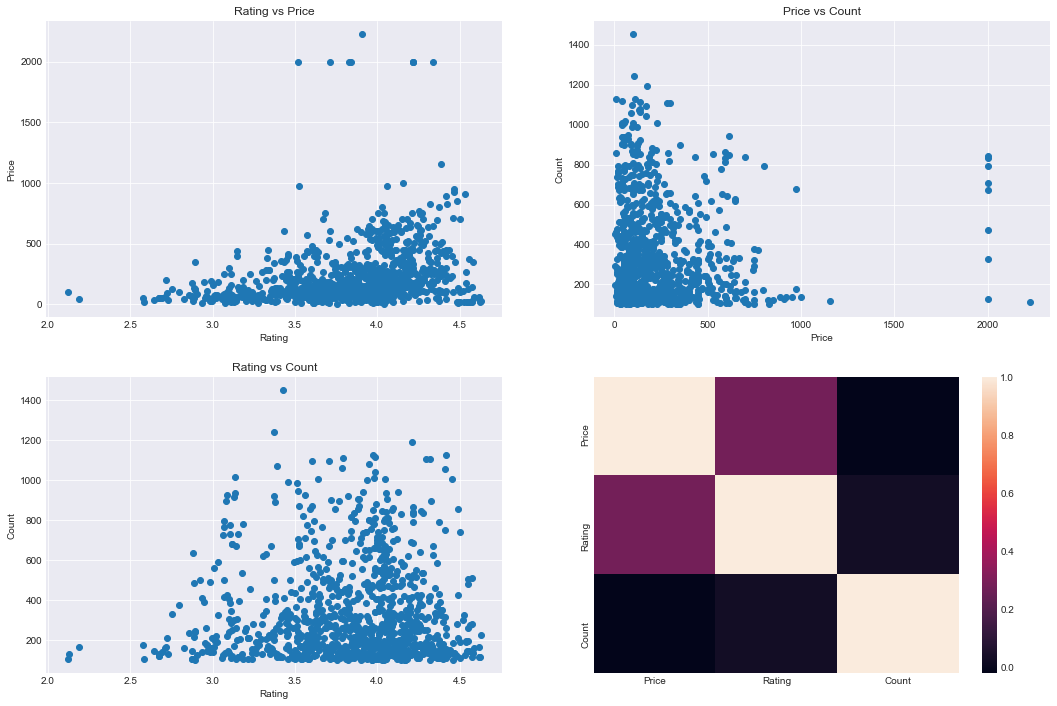

In [634]:
plt.subplots(2,2, figsize=(18,12))

plt.subplot(2,2,1)
plt.scatter("Rating", "Price", data=top1000_price_and_rating)
plt.title("Rating vs Price")
plt.xlabel("Rating")
plt.ylabel("Price")

plt.subplot(2,2,2)
plt.scatter("Price", "Count", data=top1000_price_and_rating)
plt.title("Price vs Count")
plt.xlabel("Price")
plt.ylabel("Count")

plt.subplot(2,2,3)
plt.scatter("Rating", "Count", data=top1000_price_and_rating)
plt.title("Rating vs Count")
plt.xlabel("Rating")
plt.ylabel("Count")

plt.subplot(2,2,4)
sns.heatmap(top1000_price_and_rating.corr()) # pearson correlation limited to linear relationships only

In [635]:
top1000_price_and_rating.corr()

,Price,Rating,Count
Price,1.000000,0.282069,-0.020859
Rating,0.282069,1.000000,0.030110
Count,-0.020859,0.030110,1.000000


- Rating and price have a weak positive correlation: pricier phones are more likely to satisfy their buyers
- The count of products in the top 1000 seems to be completely unaffected by their price or rating; they do heavily cluster around prices between 0-$500 and ratings of 3.5-4.5

### Brand Name

In [17]:
len(data[data["Brand Name"].isnull()])/len(data["Brand Name"])

0.15747873574328242

~16% of brand names are missing in this dataset.

Number of unique brands:

In [637]:
all_brands = data["Brand Name"].unique()
print("{} Unique brands.\n".format(len(all_brands)))
print(all_brands)

385 Unique brands.

['Samsung' 'Nokia' nan 'HTM' 'Jethro' 'e passion'
 'Cedar Tree Technologies' 'Indigi' 'Phone Baby' 'OtterBox' 'Lenovo'
 'Huawei' 'JUNING' 'Elephone' 'Plum' 'VKworld' 'NOKIA' 'Ulefone' 'Jiuhe'
 'inDigi' 'Acer' 'Aeku' 'AKUA' 'Alcatel' 'TCL Mobile' 'LG' 'amar' 'Amazon'
 'Odysseus' 'Digital SNITCH' 'star' 'Android' 'Yezz' 'Yezz Wireless Ltd.'
 'Apple' 'Apple Computer' 'Certified Refurbished'
 'Amazon.com, LLC *** KEEP PORules ACTIVE ***' 'apple' 'ARGOM TECH' 'Asus'
 'ASUS' 'ASUS Computers' 'asus' 'BlackBerry' 'Motorola' 'Palm' 'Pantech'
 'ZTE' 'ATT' 'UnAssigned' 'Atoah'
 'BlackBerry Storm 9530 Smartphone Unlocked GSM Wireless Handheld Device w/Camera Bluetooth 3.25" Touchscreen LCD'
 'WorryFree Gadgets' 'worryfree' 'iDROID USA' 'Blackberry (Rim)'
 'Research In Motion' 'BLACKBERRY' 'Black Berry' 'Blackberry' 'blackberry'
 'RIM' 'Research in Motion' 'Blackberrry' 'Storm' 'Blackview' 'BLU'
 'Various' 'CT-Miami LLC' 'blu' 'BLUBOO' 'Bluboo' 'Iridium' 'AeroAntenna'
 'BlueCosm

Missing brands:

In [642]:
missing_brands_df = data[data["Brand Name"].isnull()]
len(missing_brands_df)

65171

In [659]:
missing_brands_df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
110,((Unlocked))BlackBerry Bold 9650 Unlocked Clean ESN Smartphone non camera,NaN,269.1,2,when i got phone it wouldn't work I took it to a Verizon store here the battery didn't work even when I charged it for 12 hrs Verizon put another used battery in phone it started to work,0.0
111,((Unlocked))BlackBerry Bold 9650 Unlocked Clean ESN Smartphone non camera,NaN,269.1,4,I liked,0.0
112,((Unlocked))BlackBerry Bold 9650 Unlocked Clean ESN Smartphone non camera,NaN,269.1,5,Great. Arrived quickly.,0.0
113,((Unlocked))BlackBerry Bold 9650 Unlocked Clean ESN Smartphone non camera,NaN,269.1,4,"Phone works great, you may have to get a sum card adapter to make micro sim cats work.",0.0
114,((Unlocked))BlackBerry Bold 9650 Unlocked Clean ESN Smartphone non camera,NaN,269.1,5,"Avianna LLC is an incredible seller. The phone did take a while to get to my place however when the phone didn't work on my provider, Andrew stayed on the phone with me with tech support with my service provider for over 1.5 hrs just to try and get the phone to work. When that didn't work he immediately sent a replacement phone for me to use. He is very receptive to feedback and is constantly in contact when a problem arises. The product was as described, used Sprint Unlocked Blackberry Bold and I believe it is the service from my provider that was the problem.",0.0


In [660]:
missing_brands_df.tail()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
413097,ZTE V987 Android 4.1 MT6589 Quad Core 1.2GHz Dual Sim 5.0 inch HD 1G RAM 8.0MP,NaN,167.22,5,EXCELENTE,0.0
413098,ZTE V987 Android 4.1 MT6589 Quad Core 1.2GHz Dual Sim 5.0 inch HD 1G RAM 8.0MP,NaN,167.22,2,Not as expected so I returned this phone,0.0
413099,ZTE V987 Android 4.1 MT6589 Quad Core 1.2GHz Dual Sim 5.0 inch HD 1G RAM 8.0MP,NaN,167.22,5,very well,0.0
413100,ZTE V987 Android 4.1 MT6589 Quad Core 1.2GHz Dual Sim 5.0 inch HD 1G RAM 8.0MP,NaN,167.22,5,excelente,0.0
413101,ZTE V987 Android 4.1 MT6589 Quad Core 1.2GHz Dual Sim 5.0 inch HD 1G RAM 8.0MP,NaN,167.22,5,great product! i loved!,0.0


- There are over 60,000 samples with missing brands, but they're mostly for the same products
- The brand of each product seems to occur early on in the product name string

With this in mind, the algorithm for finding the brand name will do the following:

- Iterate through all known brands and see if they are in the name string
- If found in the name string, will use its index in the string as a key in a temporary dictionary that is paired with the brand name
- Return the brand paired to the smallest index key (the first brand that came in the product name string)
- Add the product string and its found brand as a key-value pair in a global product_dict dictionary
- Check to see if the product string already exists in the product_dict dictionary at the beginning of each function call; if it exists it will just grab the brand from there
- This avoids having to do the slow iteration through all known brands when looking at duplicate products

In [654]:
def find_brand(row):
    global product_dict # global dict
    name = row["Product Name"] # grab product string
    if name in product_dict:
        return product_dict[name] # if product string already exists in global dict use its brand
    else:
        found_brands = {} # initialize empty dict to store found brands
        for brand in all_brands:
            if str(brand) in name:
                found_brands[name.find(str(brand))] = brand # if a known brand is in the string add it to found_brands
                                                            # keying it with its index in the string
        try:
            first_brand = found_brands[min(list(found_brands.keys()))] # take the first brand found in the string 
            product_dict[name] = first_brand # add product string and found brand to global dict
            return first_brand
        except ValueError:
            pass # pass if no brand is found
    

In [655]:
product_dict = {}
found_brands = missing_brands_df.apply(find_brand, axis=1)

Quick look to check if it worked:

In [661]:
found_brands[10000:10005]

53253    Apple
53254    Apple
53255    Apple
53256    Apple
53257    Apple
dtype: object

In [662]:
found_brands[60000:60005]

389822    Sony
389823    Sony
390911    Sony
390912    Sony
390913    Sony
dtype: object

Fill NAs and compare:

In [666]:
data_before = data.copy() # to compare with after filling NAs

data["Brand Name"] = data["Brand Name"].fillna(found_brands) 
data["Brand Name"] = data["Brand Name"].fillna("Other")

Top brand frequencies before and after filling NAs:

In [667]:
print('Before filling NAs')
print(data_before["Brand Name"].value_counts()[:10])
print("\n" + '--'*10 + "\n")
print('After filling NAs')
print(data["Brand Name"].value_counts()[:10])

Before filling NAs
Samsung       65747
BLU           63248
Apple         58186
LG            22417
BlackBerry    16872
Nokia         16806
Motorola      13417
HTC           12724
CNPGD         12613
OtterBox      7989 
Name: Brand Name, dtype: int64

--------------------

After filling NAs
Apple             76546
Samsung           68799
BLU               64229
LG                28023
Nokia             19037
BlackBerry        17349
Motorola          15482
CNPGD             13820
HTC               13270
Samsung Galaxy    11448
Name: Brand Name, dtype: int64


- Apple has dethroned Samsung as most common brand; makes sense considering Apple had highest product name frequency
- Samsung Galaxy enters top 10

Visualizing frequencies of top 25 brands:

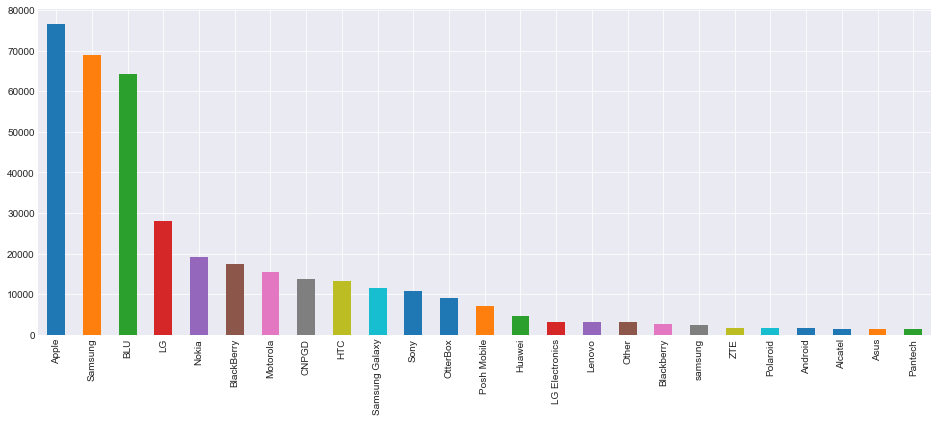

In [26]:
plt.figure(figsize=(16,6))
data_after["Brand Name"].value_counts()[:25].plot("bar")

- Apple, Samsung, and BLU take up the lions share of the market
- Samsung is the true leader of this dataset if we add Samsung Galaxy and 'samsung' name brands to its total

Visualing average rating for top 10 brands:

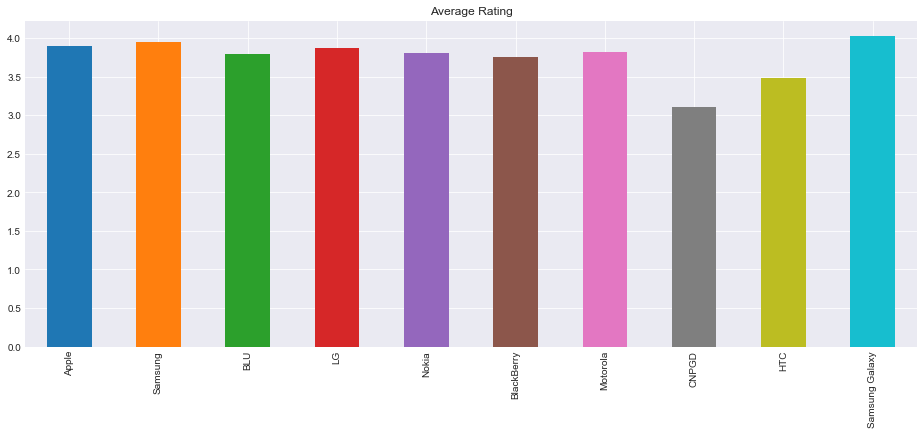

In [672]:
top10_brands_ix = data["Brand Name"].value_counts()[:10].index
top10_average_ratings = data.groupby('Brand Name')['Rating'].mean()[top10_brands_ix]
top10_average_ratings.plot(kind='bar', figsize=(16,6))
plt.title('Average Rating')
plt.show()

- All but CNPGD and HTC are averaging about a 3.8, while Samsung Galaxy leads with a 4.0 average

Visualizing average price for 10 top brands:

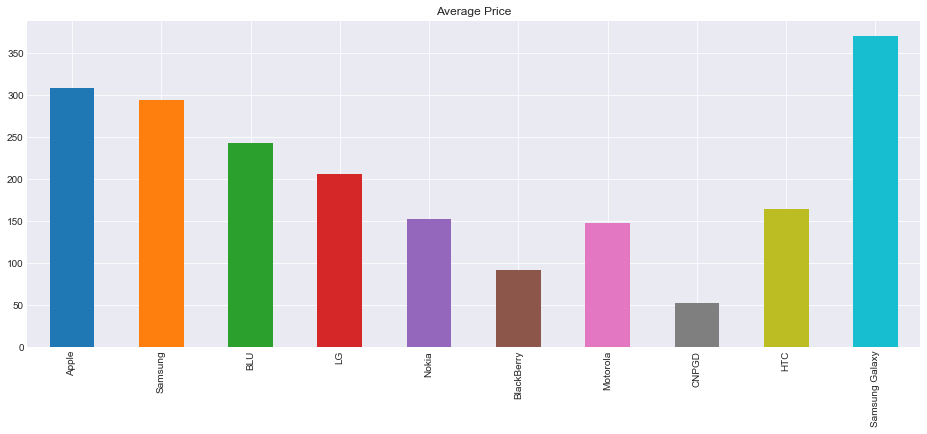

In [673]:
top10_average_price = data.groupby('Brand Name')['Price'].mean()[top10_brands_ix]
top10_average_price.plot(kind='bar', figsize=(16,6))
plt.title('Average Price')
plt.show()

- Samsung Galaxy has highest price by decent margin; perhaps explains highest average rating due to high product quality
- Approx. $300 seems like the pricepoint where competition between leaders Apple and Samsung is at

## Sentiment Analysis

Moving onto sentiment analysis, I attempt to build a classifer that can gauge a review's general sentiments by looking at its text.

### Set target variable (Sentiments)

In the interest of building a more accurate classifier, I will make this task a bit easier by binning the ratings from 1-5 into negative, neutral, and positive categories. There can be a lot of nuance in someone rating a product a 2 instead of 1 for example, but both of these scores are generally negative.

In [329]:
def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"

In [330]:
data = df.copy()
data['Sentiment'] = data['Rating'].apply(sentiments)

In [331]:
data['Sentiment'][:20]

0     Positive
1     Positive
2     Positive
3     Positive
4     Positive
5     Negative
6     Negative
7     Negative
8     Positive
9     Neutral 
10    Neutral 
11    Positive
12    Positive
13    Negative
14    Positive
15    Negative
16    Positive
17    Positive
18    Positive
19    Neutral 
Name: Sentiment, dtype: object

### Split into train/test

First, I drop any samples with no review text and shuffle all the reviews:

In [337]:
print("Before {}".format(len(data)))
complete = data.dropna(subset=['Reviews']) # remove samples with no review text
shuffled_ix = np.random.permutation(len(complete))
complete = complete.reindex(shuffled_ix)
print("After {}".format(len(complete)))

Before 413840
After 413778


Now that all the samples have been randomly shuffled, I will make a training set of 90,000 samples total (uniformly distributing positive, neutral, and negative reviews) by slicing the first 30,000 samples of each sentiment. I will slice the next 1000 samples of each to form the testing set:

In [434]:
train_positive = complete[complete['Sentiment'] == 'Positive'][:30000]
train_neutral = complete[complete['Sentiment'] == 'Neutral'][:30000]
train_negative = complete[complete['Sentiment'] == 'Negative'][:30000]

test_positive = complete[complete['Sentiment'] == 'Positive'][30000:31000]
test_neutral = complete[complete['Sentiment'] == 'Neutral'][30000:31000]
test_negative = complete[complete['Sentiment'] == 'Negative'][30000:31000]

train = pd.concat([train_positive, train_neutral, train_negative])
test = pd.concat([test_positive, test_neutral, test_negative])

In [435]:
X_train = train['Reviews']
Y_train = train['Sentiment']


X_test = test['Reviews']
Y_test = test['Sentiment']

In [436]:
print(len(X_train), len(X_test))

90000 3000


90,000 training samples and 1000 testing samples

### Extract Features

I will use the 'Bag of Words' approach to building my model. This approach seeks to associate the appearance of certain words in reviews with the target sentiments. To do this, I need to first find the frequency of each word in the entirety of the training data and assign it to a column of a $MxN$ vector matrix where:

- $M$ is the number of samples in either the training or test set
- $N$ is a word that was found in the training set
- $J$ is a word's frequency expressed as a percentage
- $M,N[J]$ is the frequency $J$ of the $N$th word in the $M$th sample

This matrix can be formed using Scikit-Learn's **CountVectorizer** transformer:

In [437]:
from sklearn.feature_extraction.text import CountVectorizer

In [439]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(90000, 37669)

90,000 sample rows, 37,669 word columns

**CountVectorizer** gives us the count of each $N$ word in every $M$ sample. It creates a sparse matrix (i.e. a vector matrix where most elements are 0 and memory isn't used representing them) since only a relatively small subset of unique words found across the entirety of the training data will be in a single review. However, using words' counts as features is flawed as some longer reviews might have higher absolute word counts but may not be expressing necessarily stronger sentiments.

A more nuanced approach is to turn individual word counts into frequency percentages ($J$) using Scikit-Learn's **TfidfTransformer**. It does this by dividing the occurrences of each word by the number of total words in the review (**Tf** = 'term frequency'). A further refinement in addition to this is weighing common words across many reviews less; this will help the model assign less value to unimportant stopwords like 'the', 'if', 'a', 'that', etc. This technique is known as using the 'inverse document frequency' (**idf**).

In [440]:
from sklearn.feature_extraction.text import TfidfTransformer

In [441]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

In [442]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(90000, 37669)

Merging these two transformations into a single pipeline:

In [497]:
from sklearn.pipeline import Pipeline

In [498]:
feat_pipe = Pipeline([('count_vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer())])

This pipeline can be fit to the training set and then transform other samples into a $MxN$ frequency matrix using the $N$ words found in the training set.

Let's use it to create our tfidf transformed training and testing sets:

In [499]:
X_train_tfidf = feat_pipe.fit_transform(X_train)
X_test_tfidf = feat_pipe.transform(X_test)

### Test Models

Quickly test a number of different classification models to see how well they fit the training data:

#### Logistic Regression

In [465]:
from sklearn.linear_model import LogisticRegression

In [466]:
log_clf = LogisticRegression().fit(X_train_tfidf, Y_train)

In [484]:
predicted = log_clf.predict(X_train_tfidf)

In [485]:
np.mean(predicted == Y_train)

0.8061666666666667

#### SVM

In [453]:
from sklearn.svm import LinearSVC
svm_clf = LinearSVC().fit(X_train_tfidf, Y_train)

In [486]:
predicted = svm_clf.predict(X_train_tfidf)

In [488]:
np.mean(predicted == Y_train)

0.8612222222222222

#### Decision Tree

In [458]:
from sklearn.tree import DecisionTreeClassifier

In [459]:
tree_clf = DecisionTreeClassifier().fit(X_train_tfidf, Y_train)

In [489]:
predicted = tree_clf.predict(X_train_tfidf)

In [490]:
np.mean(predicted == Y_train)

0.9849111111111111

- This is very strong; likely overfitting the training set

#### Random Forest

In [470]:
from sklearn.ensemble import RandomForestClassifier

In [471]:
forest_clf = RandomForestClassifier().fit(X_train_tfidf, Y_train)

In [491]:
predicted = forest_clf.predict(X_train_tfidf)

In [483]:
np.mean(predictions == Y_train)

0.9807777777777777

- Overfitting again

#### Multinomial Naive Bayes

In [452]:
from sklearn.naive_bayes import MultinomialNB

In [462]:
naive_clf = MultinomialNB().fit(X_train_tfidf, Y_train)

In [493]:
predicted = naive_clf.predict(X_train_tfidf)

In [494]:
np.mean(predicted == Y_train)

0.7587666666666667

Tree-based classifiers were the most accurate, but its highly likely that they both were overfitting the training set. I'll still use the random forest as the chosen classifier for my model though, as its generalized accuracy will likely still be higher than the other classifiers.

### Fine tuning the Random Forest classifier

I will tune the Random Forest classifier using Scikit-Learn's **GridSearchCV** function. It takes all available combinations of hyperparameter values and performs K-fold cross-validation for each one. K-fold cross-validation essentially splits the training data into $K$ chunks and trains $K$ different classifiers using $K-1$ different chunk combinations, testing each one on the single chunk left out. These testing results are then averaged to produce a generalized score for the fitness of that given model and its hyperparameters.

This entire process can be very slow, because you're training and testing the model $K$ times multiplied by the product of all the different hyperparameter combinations. It's made even slower in this case because each Random Forest classifier works by training $N$ number of trees on its own different data chunks to create its own generalized score.

In [528]:
from sklearn.model_selection import GridSearchCV

In [541]:
param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [5000, 15000, 'log2','auto'], 'bootstrap': [False]}
]

In [542]:
grid_search = GridSearchCV(forest_clf, param_grid, cv=5, verbose=2)

3 **n_estimators** x 4 **max_features** x 1 **bootstrap** x 5 K-Folds for each cross validation = 60 trained random forests

Each **n_estimator** hyperparameter value represents the number of trees trained in the Random Forest, so:

(3 trees x 4 **max_features** x 5 K-folds) + (10 trees x 4 **max_features** x 5 K-folds) + (30 trees x 4 **max_features** x 5 K-folds) = 860 individual trees trained

This will take a long time!

In [543]:
grid_search.fit(X_train_tfidf, Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] bootstrap=False, max_features=5000, n_estimators=3 ..............
[CV]  bootstrap=False, max_features=5000, n_estimators=3, total= 1.9min
[CV] bootstrap=False, max_features=5000, n_estimators=3 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV]  bootstrap=False, max_features=5000, n_estimators=3, total= 2.0min
[CV] bootstrap=False, max_features=5000, n_estimators=3 ..............
[CV]  bootstrap=False, max_features=5000, n_estimators=3, total= 2.0min
[CV] bootstrap=False, max_features=5000, n_estimators=3 ..............
[CV]  bootstrap=False, max_features=5000, n_estimators=3, total= 2.0min
[CV] bootstrap=False, max_features=5000, n_estimators=3 ..............
[CV]  bootstrap=False, max_features=5000, n_estimators=3, total= 2.0min
[CV] bootstrap=False, max_features=5000, n_estimators=10 .............
[CV]  bootstrap=False, max_features=5000, n_estimators=10, total= 6.6min
[CV] bootstrap=False, max_features=5000, n_estimators=10 .............
[CV]  bootstrap=False, max_features=5000, n_estimators=10, total= 6.7min
[CV] bootstrap=False, max_features=5000, n_estimators=10 .............
[CV]  bootstrap=False, max_features=5000, n_estimators=10, total= 6.5min
[CV] bootstrap=False, max_features=5000, n_estimators=10 ..........

[CV]  bootstrap=False, max_features=auto, n_estimators=30, total= 9.7min
[CV] bootstrap=False, max_features=auto, n_estimators=30 .............
[CV]  bootstrap=False, max_features=auto, n_estimators=30, total= 9.8min


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 576.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [5000, 15000, 'log2', 'auto'], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

After almost 10 hours, the search is complete.

Let's first assign the best estimator to a variable and see its hyperparamter combo:

In [682]:
final_model = grid_search.best_estimator_
grid_search.best_params_

{'bootstrap': False, 'max_features': 'auto', 'n_estimators': 30}

More tree estimators seemed to help. Now let's the score this model achieved:

In [683]:
grid_search.best_score_

0.8367444444444444

Much less than the 98% fit to the entire training set. Cross-validation gives a much better idea of how well the Random Forest generalizes to new samples.

Since the grid search took so long, I'm going to write the final model to my hard drive using Python's pickle module so I don't lose it:

In [674]:
import os
import pickle

In [680]:
path = os.path.join(os.getcwd(), 'final_model.p')
pickle.dump(final_model, open(path, 'wb'))

## Final Model

All that's left to do is see how the final model performs on the test set:

In [684]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [685]:
predictions = final_model.predict(X_test_tfidf)

To evaluate the model we'll look at the **precision**, **recall**, and **f1-score** for each target label as well as averages and the **accuracy** for the entire set.

- **precision** is the percentage of true positive predictions over all positive predictions, giving an idea of the model's ability to correctly classify only relevant instances

- **recall** is the percentage of true positives over all the positives in the dataset, giving an idea of how well the model can identify correct instances

- **f1-score** is the harmonized mean of precision and recall; it is higher when both of precision and recall are high and punishes extreme discrepancies between them

- **accuracy** is simply the percentage of correct predictions in the entire testing set

In [686]:
print(classification_report(Y_test, predictions))
print('Accuracy: {}'. format(accuracy_score(Y_test, predictions)))

             precision    recall  f1-score   support

   Negative       0.81      0.92      0.86      1000
    Neutral       0.89      0.79      0.84      1000
   Positive       0.87      0.85      0.86      1000

avg / total       0.86      0.85      0.85      3000

Accuracy: 0.855


- The model performs well across all three categories with an average f1-score and overall accuracy of 0.85
- Positive sentiments are closely balanced between precision and recall, but the difference is a bit more pronounced for Negative and Neutral labels
- With a higher recall for Negative labels it seems that the model was able to create strong word associations that captured most negative expressions. It makes sense to me that precision might be lower here since negative words could be paired with words to flip their meanings around (e.g. 'not broken').
- Neutral's scores are very interesting because it should be the more difficult label to predict; it is less extreme and obvious than Positive or Negative sentiments. Low recall is to be expected considering how it could be easy to see enough positive or negative words in a review to predict it into that respective category. The high precision here shows that the model was more likely to predict positive or negative, but predicted neutral in only the most clear-cut cases.

Overall the model performed admirably with the simplified task of predicting the reviews' sentiments as opposed to their actual ratings. The scores for the model could likely be pushed into +90% ranges if Neutral sentiments were ignored, as the differences between only Positive and Negative sentiments are easier to discern.

Now let's see the model in action with some new reviews:

In [622]:
docs_new = ['The phone seemed cheap, I threw it down the stairs and the screen got scratched.', # negative
            'My new favorite phone - it works very well. My baby is quite happy chewing on it.', # positive
            'The phone is simply ok for the price. Not perfect but it gets the job done.'] # neutral|

In [623]:
docs_prepared = feat_pipe.transform(docs_new)
forest_clf.predict(docs_prepared)

array(['Negative', 'Positive', 'Neutral'], dtype=object)